# Neighborhood Venues Data Mining

Combines and deduplicates geospatial neighborhood data and requests Foursquare nearby venues to build profile of each neighborhood.

In [1]:
import pandas as pd
import numpy as np

import glob

import matplotlib.pyplot as plt
import folium

from foursquare import fetch_venues, venue_frequency, rank_venues_by_frequency
from geocoder import enrich_neighborhoods_with_geocoder, map_neighborhoods, map_clusters

### Tidy, Compile global datasets

In [2]:
beijing = pd.read_csv('data/beijing_neighborhood_coords.csv', index_col=0)
beijing.insert(1, 'City', 'Beijing')
beijing.head()

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973640,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006


In [12]:
frankfurt = pd.read_csv('data/frankfurt_neighborhood_coords.csv', index_col=0)
frankfurt.insert(1, 'City', 'Frankfurt')

hongkong = pd.read_csv('data/hong_kong_neighborhood_coords.csv', index_col=0)
hongkong.insert(1, 'City', 'Hong Kong')

london = pd.read_csv('data/london_neighborhood_coords.csv', index_col=0)
london.insert(1, 'City', 'London')

nyc = pd.read_csv('data/new_york_city_neighborhood_coords.csv', index_col=0)
nyc.insert(1, 'City', 'New York City')

shanghai = pd.read_csv('data/shanghai_neighborhood_coords.csv', index_col=0)
shanghai.insert(1, 'City', 'Shanghai')

singapore = pd.read_csv('data/singapore_neighborhood_coords.csv', index_col=0)
singapore.insert(1, 'City', 'Singapore')

tokyo = pd.read_csv('data/tokyo_neighborhood_coords.csv', index_col=0)
tokyo.insert(1, 'City', 'Tokyo')

toronto = pd.read_csv('data/toronto_neighborhood_coords.csv', index_col=0)
toronto.insert(1, 'City', 'Toronto')

zurich = pd.read_csv('data/zurich_neighborhood_coords.csv', index_col=0)
zurich.insert(1, 'City', 'Zurich')

world_coordinates = pd.concat([beijing, frankfurt, hongkong, london, nyc, shanghai, singapore, tokyo, toronto, zurich]).reset_index(drop=True)
world_coordinates

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973640,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006
...,...,...,...,...
1389,Langstrasse,Zurich,47.377273,8.526415
1390,Enge,Zurich,47.361789,8.528708
1391,Lindenhof,Zurich,47.372916,8.540176
1392,Leimbach,Zurich,47.390254,8.581406


### Handle duplicates

In [13]:
d = world_coordinates.duplicated
d

<bound method DataFrame.duplicated of           Neighborhood     City   Latitude   Longitude
0               Yuqiao  Beijing  39.898820  116.670814
1          Shigezhuang  Beijing  39.931943  116.557680
2     Beitaipingzhuang  Beijing  39.973640  116.363844
3       Yongdingmenwai  Beijing  39.866794  116.392355
4       Jinding Avenue  Beijing  39.934977  116.389006
...                ...      ...        ...         ...
1389       Langstrasse   Zurich  47.377273    8.526415
1390              Enge   Zurich  47.361789    8.528708
1391         Lindenhof   Zurich  47.372916    8.540176
1392          Leimbach   Zurich  47.390254    8.581406
1393         Wipkingen   Zurich  47.393495    8.528602

[1394 rows x 4 columns]>

In [14]:
world_coordinates.shape

(1394, 4)

In [15]:
world_coordinates.drop_duplicates(inplace=True)
world_coordinates.shape

(1393, 4)

In [27]:
world_coordinates.drop_duplicates(subset=['Latitude', 'Longitude'], inplace=True)
world_coordinates.reset_index(inplace=True, drop=True)

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973640,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006
...,...,...,...,...
1389,Langstrasse,Zurich,47.377273,8.526415
1390,Enge,Zurich,47.361789,8.528708
1391,Lindenhof,Zurich,47.372916,8.540176
1392,Leimbach,Zurich,47.390254,8.581406


In [28]:
world_coordinates.reset_index(inplace=True, drop=True)

10% of locations are duplicates! :(

In [29]:
world_coordinates

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973640,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006
...,...,...,...,...
1262,Langstrasse,Zurich,47.377273,8.526415
1263,Enge,Zurich,47.361789,8.528708
1264,Lindenhof,Zurich,47.372916,8.540176
1265,Leimbach,Zurich,47.390254,8.581406


In [30]:
world_coordinates['City'].value_counts()

New York City    306
Hong Kong        229
Toronto          166
Singapore        145
Shanghai         129
Beijing          111
Tokyo             72
Frankfurt         46
London            32
Zurich            31
Name: City, dtype: int64

In [31]:
world_coordinates.to_csv('data/world_neighborhood_coords.csv')

# world_coordinates = pd.read_csv('data/world_neighborhood_coords.csv', index_col=0)
# world_coordinates

### Fetch neighborhood venues from Foursquare

In [34]:
world_venues = fetch_venues(names=world_coordinates['Neighborhood'],
                                   latitudes=world_coordinates['Latitude'],
                                   longitudes=world_coordinates['Longitude']
                                  )
world_venues

,Neighborhood,Latitude,Longitude,Venue,Venue Category
0,Beitaipingzhuang,39.973640,116.363844,Huayang Nianhua Guizhou Hometown Restaurant (贵...,Guizhou Restaurant
1,Beitaipingzhuang,39.973640,116.363844,Pizza Hut (必胜客),Pizza Place
2,Beitaipingzhuang,39.973640,116.363844,McDonald's (麦当劳),Fast Food Restaurant
3,Beitaipingzhuang,39.973640,116.363844,嘉和一品 Jiahe Yipin Congee,Chinese Restaurant
4,Beitaipingzhuang,39.973640,116.363844,Mudanyuan Metro Station (地铁牡丹园站),Metro Station
...,...,...,...,...,...
15637,Wipkingen,47.393495,8.528602,Flying Pizza,Pizza Place
15638,Wipkingen,47.393495,8.528602,ototo,Japanese Restaurant
15639,Wipkingen,47.393495,8.528602,Bahnhof Zürich Wipkingen,Train Station
15640,Wipkingen,47.393495,8.528602,Tre Frattelli,Italian Restaurant


In [47]:
world_venues['Venue Category'].value_counts()

Coffee Shop            758
Café                   616
Chinese Restaurant     570
Japanese Restaurant    403
Italian Restaurant     380
                      ... 
Kosher Restaurant        1
Island                   1
Currywurst Joint         1
Zoo Exhibit              1
Trattoria/Osteria        1
Name: Venue Category, Length: 522, dtype: int64

In [56]:
# reset 'City' which was lost in venues fetcher
world_venues = pd.merge(left = world_coordinates[['Neighborhood', 'City']], right=world_venues, on='Neighborhood', how='inner')
world_venues.drop_duplicates(inplace=True)
world_venues

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category
0,Beitaipingzhuang,Beijing,39.973640,116.363844,Huayang Nianhua Guizhou Hometown Restaurant (贵...,Guizhou Restaurant
1,Beitaipingzhuang,Beijing,39.973640,116.363844,Pizza Hut (必胜客),Pizza Place
2,Beitaipingzhuang,Beijing,39.973640,116.363844,McDonald's (麦当劳),Fast Food Restaurant
3,Beitaipingzhuang,Beijing,39.973640,116.363844,嘉和一品 Jiahe Yipin Congee,Chinese Restaurant
4,Beitaipingzhuang,Beijing,39.973640,116.363844,Mudanyuan Metro Station (地铁牡丹园站),Metro Station
...,...,...,...,...,...,...
16327,Wipkingen,Zurich,47.393495,8.528602,Flying Pizza,Pizza Place
16328,Wipkingen,Zurich,47.393495,8.528602,ototo,Japanese Restaurant
16329,Wipkingen,Zurich,47.393495,8.528602,Bahnhof Zürich Wipkingen,Train Station
16330,Wipkingen,Zurich,47.393495,8.528602,Tre Frattelli,Italian Restaurant


In [63]:
# more EDA
venues_by_city = world_venues.pivot_table(index='City', columns='Venue Category', values='Neighborhood', aggfunc='count', fill_value=0)
venues_by_city

Venue Category,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
City,,,,,,,,,,,,,,,,,,,,,
Beijing,0,1,1,0,0,0,0,0,1,0,...,0,0,0,2,0,0,0,1,0,0
Frankfurt,0,0,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hong Kong,1,5,0,0,0,1,0,0,6,1,...,4,0,5,0,0,5,0,1,1,0
London,0,0,0,0,1,0,0,0,1,0,...,1,1,6,0,0,3,0,0,0,0
New York City,0,7,2,2,0,0,0,0,66,9,...,36,3,15,0,0,28,0,0,0,0
Shanghai,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Singapore,1,2,0,0,1,0,0,0,7,0,...,1,2,1,0,0,12,0,0,0,0
Tokyo,15,3,1,1,0,0,0,0,8,0,...,1,1,1,0,27,2,16,0,0,0
Toronto,0,2,1,0,1,0,0,0,24,1,...,2,4,10,0,0,7,0,0,0,0


In [ ]:
venues_by_city.describe()

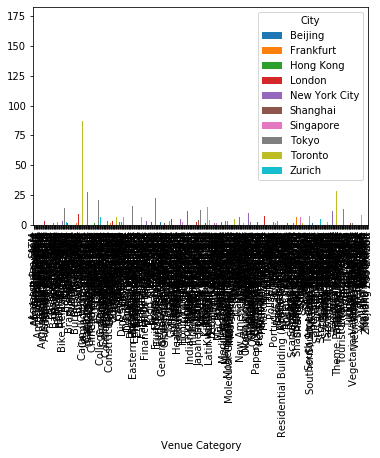

In [67]:
venues_by_city.T.plot(kind='bar')
plt.show()

In [3]:
# w.to_csv('data/world_neighborhood_venues.csv')
world_venues = pd.read_csv('data/world_neighborhood_venues.csv', index_col=0)
world_venues

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category
0,Beitaipingzhuang,Beijing,39.973639,116.363844,Huayang Nianhua Guizhou Hometown Restaurant (贵...,Guizhou Restaurant
1,Beitaipingzhuang,Beijing,39.973639,116.363844,Pizza Hut (必胜客),Pizza Place
2,Beitaipingzhuang,Beijing,39.973639,116.363844,McDonald's (麦当劳),Fast Food Restaurant
3,Beitaipingzhuang,Beijing,39.973639,116.363844,嘉和一品 Jiahe Yipin Congee,Chinese Restaurant
4,Beitaipingzhuang,Beijing,39.973639,116.363844,Mudanyuan Metro Station (地铁牡丹园站),Metro Station
...,...,...,...,...,...,...
16327,Wipkingen,Zurich,47.393495,8.528602,Flying Pizza,Pizza Place
16328,Wipkingen,Zurich,47.393495,8.528602,ototo,Japanese Restaurant
16329,Wipkingen,Zurich,47.393495,8.528602,Bahnhof Zürich Wipkingen,Train Station
16330,Wipkingen,Zurich,47.393495,8.528602,Tre Frattelli,Italian Restaurant


### Find most frequent venue types per neighborhood

In [4]:
# rows sum to 1
world_frequency = venue_frequency(world_venues)
world_frequency

   Neighborhood  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0   A Kung Ngam  0.0                0.0             0.0                0.0   
1      Aberdeen  0.0                0.0             0.0                0.0   
2      Adelaide  0.0                0.0             0.0                0.0   
3     Admiralty  0.0                0.0             0.0                0.0   
4  Agariyashiki  0.0                0.0             0.0                0.0   

   African Restaurant  Airport Gate  Airport Lounge  Airport Service  \
0                 0.0           0.0             0.0              0.0   
1                 0.0           0.0             0.0              0.0   
2                 0.0           0.0             0.0              0.0   
3                 0.0           0.0             0.0              0.0   
4                 0.0           0.0             0.0              0.0   

   American Restaurant  ...  Wine Shop  Wings Joint  Women's Store  \
0                0.000  ... 

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Gate,Airport Lounge,Airport Service,American Restaurant,...,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,A Kung Ngam,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,Aberdeen,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,Adelaide,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025,...,0.0,0.0,0.025,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,Admiralty,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.019231,0.0,0.0,0.0,0.0
4,Agariyashiki,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,Zōshigaya,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.045455,0.000000,0.0,0.0,0.0,0.0
1058,one-north,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1059,Āntíng Zhèn,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1060,"Ōmori, Ōta",0.013889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [5]:
world_frequency.to_csv('data/world_neighborhood_venues_frequency.csv')

In [6]:
world_ranked = rank_venues_by_frequency(world_frequency)
world_ranked.head()

   Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0   A Kung Ngam        History Museum           Zoo Exhibit   
1      Aberdeen           Bus Station      Sushi Restaurant   
2      Adelaide                 Hotel    Italian Restaurant   
3     Admiralty                  Café                 Hotel   
4  Agariyashiki           Event Space                  Park   

  3rd Most Common Venue 4th Most Common Venue       5th Most Common Venue  \
0     Fish & Chips Shop         Event Service                 Event Space   
1  Fast Food Restaurant       Bubble Tea Shop              Cha Chaan Teng   
2           Coffee Shop             Gastropub                         Gym   
3  Cantonese Restaurant              Tea Room                  Steakhouse   
4                Garden     Convenience Store  Financial or Legal Service   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Exhibit           Fabric Shop               Factory   
1           Supe

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A Kung Ngam,History Museum,Zoo Exhibit,Fish & Chips Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm
1,Aberdeen,Bus Station,Sushi Restaurant,Fast Food Restaurant,Bubble Tea Shop,Cha Chaan Teng,Supermarket,Athletics & Sports,Shopping Mall,Chinese Restaurant,Coffee Shop
2,Adelaide,Hotel,Italian Restaurant,Coffee Shop,Gastropub,Gym,Japanese Restaurant,Café,Restaurant,Hostel,Pizza Place
3,Admiralty,Café,Hotel,Cantonese Restaurant,Tea Room,Steakhouse,Hotel Bar,French Restaurant,Supermarket,Dessert Shop,Food Court
4,Agariyashiki,Event Space,Park,Garden,Convenience Store,Financial or Legal Service,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market


In [7]:
world_ranked.to_csv('data/world_neighborhood_venues_ranked.csv')